In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
import shutil
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model
from sklearn.mixture import GaussianMixture

**Autoencoder for Unsupervised Classification \
Advanced Physics Project \
11 August 2024**

In [2]:
# Checking GPU availability for GPU acceleration
print('Num GPUs available:', len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs available: 1


In [3]:
URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'

# Loading the dataset containing images from a URL and extracting it
path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=URL, extract=True)

# Creating the directories
base_dir = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')
train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'validation')

In [4]:
# Creating the training generator that will be used to train the autoencoder
model_datagen = ImageDataGenerator(rescale=1. / 255, validation_split=0.2)
test_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = model_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=100,
    class_mode='input',
    subset='training'
)

validation_generator = model_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=100,
    class_mode='input',
    subset='validation'
)

# Creating the generator that will allow for testing with unseen images
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    shuffle=False,
    class_mode='binary'
)

Found 1600 images belonging to 2 classes.
Found 400 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [5]:
# Creating the autoencoder layers
input_img = Input(shape=(150, 150, 3))

x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((3, 3), padding='same')(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((1, 1), padding='same')(x)

x = Conv2D(64, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((1, 1))(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((3, 3))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)

autoencoder.compile(optimizer='rmsprop', loss='mse')
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 150, 150, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 75, 75, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 75, 75, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 25, 25, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 25, 25, 64)        36928 

In [6]:
# Training the model and defining the flow of data settings
history = autoencoder.fit(
    train_generator,
    steps_per_epoch=16,  # 1600 images = batch_size * steps
    epochs=20,
    validation_data=validation_generator,
    validation_steps=4,  # 400 images = batch_size * steps
    shuffle=True,
    verbose=2)

Epoch 1/20
16/16 - 14s - loss: 0.0707 - val_loss: 0.0393 - 14s/epoch - 898ms/step
Epoch 2/20
16/16 - 4s - loss: 0.0439 - val_loss: 0.0359 - 4s/epoch - 261ms/step
Epoch 3/20
16/16 - 4s - loss: 0.0360 - val_loss: 0.0207 - 4s/epoch - 270ms/step
Epoch 4/20
16/16 - 4s - loss: 0.0278 - val_loss: 0.0206 - 4s/epoch - 273ms/step
Epoch 5/20
16/16 - 4s - loss: 0.0239 - val_loss: 0.0180 - 4s/epoch - 275ms/step
Epoch 6/20
16/16 - 4s - loss: 0.0218 - val_loss: 0.0392 - 4s/epoch - 278ms/step
Epoch 7/20
16/16 - 5s - loss: 0.0205 - val_loss: 0.0297 - 5s/epoch - 304ms/step
Epoch 8/20
16/16 - 4s - loss: 0.0199 - val_loss: 0.0187 - 4s/epoch - 267ms/step
Epoch 9/20
16/16 - 4s - loss: 0.0176 - val_loss: 0.0192 - 4s/epoch - 281ms/step
Epoch 10/20
16/16 - 4s - loss: 0.0173 - val_loss: 0.0170 - 4s/epoch - 271ms/step
Epoch 11/20
16/16 - 4s - loss: 0.0163 - val_loss: 0.0180 - 4s/epoch - 279ms/step
Epoch 12/20
16/16 - 4s - loss: 0.0157 - val_loss: 0.0160 - 4s/epoch - 276ms/step
Epoch 13/20
16/16 - 4s - loss: 0.01

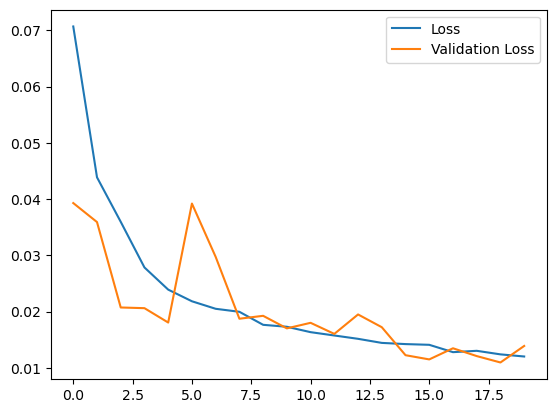

In [7]:
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

In [8]:
# Creating the encoder model
encoder = Model(input_img, encoded)

# Extracting features using the encoder
encoded_features = encoder.predict(train_generator)

# Reshaping the encoded features
encoded_features_flat = encoded_features.reshape(encoded_features.shape[0], -1)

# Standardizing the features
scaler = StandardScaler()
encoded_features_flat = scaler.fit_transform(encoded_features_flat)

# Applying PCA for dimensionality reduction (optional)
pca = PCA(n_components=50)
encoded_features_flat = pca.fit_transform(encoded_features_flat)

16/16 [==============================] - 4s 217ms/step


In [9]:
# Apply Gaussian Mixture Model (GMM) clustering to the latent features
gmm = GaussianMixture(n_components=2, random_state=42)
gmm.fit(encoded_features_flat)
cluster_labels = gmm.predict(encoded_features_flat)

C:\Users\suria\anaconda3\envs\tf_env\lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=7.
  warnings.warn(


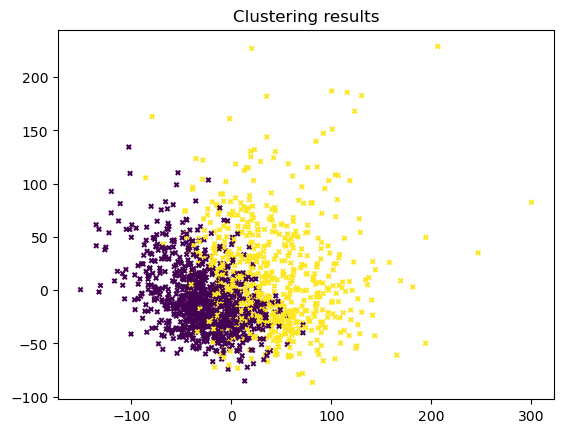

In [13]:
# Visualizing the clusters
plt.scatter(encoded_features_flat[:, 0], encoded_features_flat[:, 1], c=cluster_labels, cmap='viridis', marker='x', s=10)
plt.title('Clustering results')
plt.show()

1/1 [==============================] - 1s 514ms/step


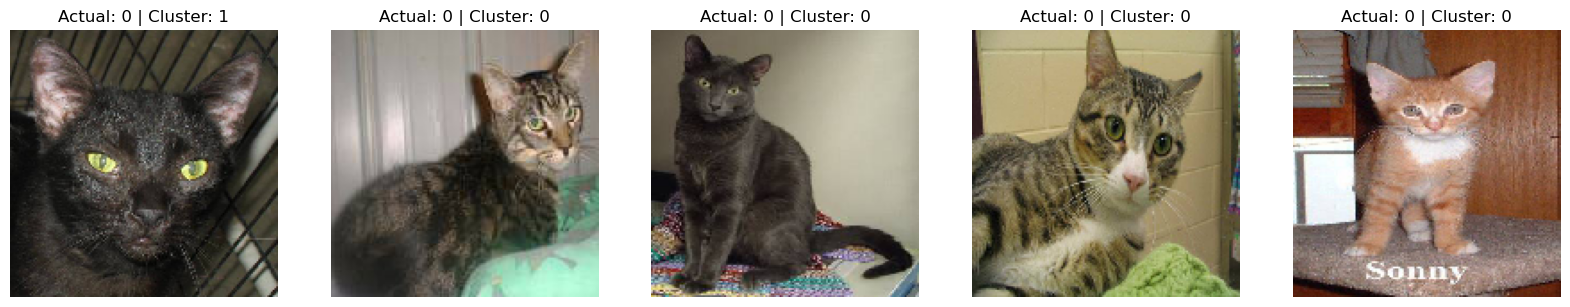

In [11]:
# Getting one batch of test images
X_test, Y_test = next(test_generator)

# Generating 5 random integers
random_indices = np.random.randint(len(X_test), size=5)

# Getting 5 random images and their corresponding labels
X_test = X_test[random_indices]
Y_test = Y_test[random_indices]

# Getting corresponding encoded features for the test set
encoded_test_features = encoder.predict(X_test)
encoded_test_features_flat = encoded_test_features.reshape(encoded_test_features.shape[0], -1)
encoded_test_features_flat = scaler.transform(encoded_test_features_flat)
encoded_test_features_flat = pca.transform(encoded_test_features_flat)

# Predicting clusters for the test set
test_cluster_labels = gmm.predict(encoded_test_features_flat)

# Displaying the first 5 images, their actual labels, and predicted clusters
n = 5
plt.figure(figsize=(20, 4))
for i in range(n):
    ax = plt.subplot(1, n, i + 1)
    plt.imshow(X_test[i].reshape(150, 150, 3))
    plt.title(f"Actual: {int(Y_test[i])} | Cluster: {test_cluster_labels[i]}")
    plt.axis('off')
plt.show()